# Credit Card Fraud Detection

This notebook illustrates techniques and machine learning algorithms for detecting fradulent credit card transactions.
Common issue with this types of problems is class imbalance. We combat this issue with over and udersampling techniques. Modeling is done with `Logistic Regression` and `Random Forest` classifiers. Let's get started.

<img src="images/ccf.jpeg" alt="Credit Card Fraud Prevention" />

## What is dataset look like?

- The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

- It contains only numerical input variables which are the result of a **PCA** transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features _**V1, V2, … V28**_ are the principal components obtained with **PCA**, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

- Given the class imbalance ratio, we recommend measuring the accuracy using the **Area Under the Precision-Recall Curve (AUPRC)**. Confusion matrix accuracy is not meaningful for unbalanced classification.

- Data is taken from **kaggle.com**: https://www.kaggle.com/mlg-ulb/creditcardfraud

## TL;DR

| Dataset | Model | Tuned | Precision | Recall | F1 | AUC |
| --- | --- | --- | --- | --- | --- | --- |
| Upsampling | Random Forest | No | 0.86 | 0.77 | **0.81** | 97% |
| Imbalanced | Logistic Regression | Yes | 0.54 | 0.82 | 0.65 | 97% |
| Downsampling | Logistic Regression | No | 0.05 | 0.82 | 0.10 | 93% |
| Upsampling | Logistic Regression | No | 0.01 | 0.94 | 0.02 | 97% |
| Downsampling | Random Forest | No | 0.00 | 1.00 | 0.00 | 97% |

## <span id="toc">Table of Contents</span>

1. <a href="#eda">Exploratory Data Analysis</a>
    - <a href="#eda_1">1.1 Target Variable Imbalance</a>
    - <a href="#eda_2">1.2 Checking for Outliers</a>
    - <a href="#eda_3">1.3 Correlations</a>    
    - <a href="#eda_4">1.4 Features Visualization (2D) with Matplotlib</a>
    - <a href="#eda_5">1.5 Features Visualization (3D) with Plotly</a>
2. <a href="#preprocessing">Preprocessing</a>
    - <a href="#preprocessing_1">2.1 Train-Test Split</a>
    - <a href="#preprocessing_2">2.2 Scaling</a>
    - <a href="#preprocessing_3">2.3 Class Imbalance (downsampling)</a>
    - <a href="#preprocessing_4">2.4 Class Imbalance (upsampling)</a>
3. <a href="#modeling">Modeling</a>
    - <a href="#modeling_1">3.1 Isolation Forest</a>
    - <a href="#modeling_2">3.2 Hyper Parameters Tuning for Logistic Regression (Imbalanced Data)</a>
    - <a href="#modeling_3">3.3 Logistic Regression with Optimal Parameters (Imbalanced Data)</a>
    - <a href="#modeling_4">3.4 Logistic Regression on Balanced Data (Downsampling)</a>
    - <a href="#modeling_5">3.5 Logistic Regression on Balanced Data (Upsampling)</a>
    - <a href="#modeling_6">3.6 Random Forest on Balanced Data (Downsampling)</a>
    - <a href="#modeling_7">3.7 Random Forest on Balanced Data (Upsampling)</a>
4. <a href="#conclusion">Conclusion</a>

## Importing Libraries

In [1]:
# Data manipulation, visualization
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns
from time import time

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC
import xgboost as xgb

# Preprocessing, dimensionality reduction
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
#from sklearn.decomposition import SparsePCA
#from sklearn.decomposition import TruncatedSVD
#from sklearn.manifold import TSNE
#from sklearn.pipeline import make_pipeline

# Evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve

import warnings
warnings.filterwarnings('ignore')

In [49]:
def evaluation(model, X_train, y_train, X_test, y_test, y_pred) -> None:
    print(classification_report(y_test, y_pred))
    print('-' * 80)
    recall_cv = cross_val_score(model, X_test, y_test, cv=5, scoring='recall')
    print(f'Cross-Validation Score (Recall): {recall_cv.mean()}')
    print('-' * 80)
    plt.rcParams['figure.dpi'] = 72
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')
    plt.show()
    print('-' * 80)
    logreg_auc = plot_roc_curve(model, X_test, y_test)
    plt.show()

## Loading Data

In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
print(f'Dataset size: {len(df)}')
print(f'Features: {df.shape[1]}')

Dataset size: 284807
Features: 31


### Quick Glimpse at the Data

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Checking for NULL

Dataset has no null values

In [5]:
df.isna().sum().sum()

0

### Describe

Looking at the data we can tell that `Amount` and `Time` are not scaled and most of the feauters have outliers

In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## <span id="eda">1. EDA</span>&nbsp;&nbsp;<a href="#toc" title="Back to the table of contents">up</a>

### <span id="eda_1">1.1 Target Variable Imbalance</span>

Target Variable(Class) is extremely imbalanced because most of the transactions are non fraudulent (`class 0`). 

This presents two problems:
1. Model will have trouble to learn fradulent transactions because there is little data
2. Evaluation of the model cannot be done with simple accuracy because even if the model wouldn't be able to correcly identify fradulent transactions at all it still will be correct **99.998%** of times

To solve this problem we most likely will be using over/undersampling technique which comes with `imblearn` package.

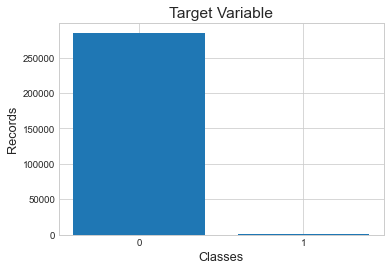

In [7]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.dpi'] = 70
plt.bar(
    df.Class.value_counts().keys(),
    df.Class.value_counts().values,
    tick_label = [0, 1]
)
plt.title('Target Variable', fontsize=16)
plt.xlabel('Classes', fontsize=13)
plt.ylabel('Records', fontsize=13)
plt.show()

### <span id="eda_2">1.2 Checking for Outlliers</span>

In [8]:
print(f'Maximum amount for normal transaction: {df[df.Class==0]["Amount"].max():>14}')
print(f'Maximum amount for fraudulent transaction: {df[df.Class==1]["Amount"].max():>10}')

Maximum amount for normal transaction:       25691.16
Maximum amount for fraudulent transaction:    2125.87


Average transaction amount is **88**, but  some of the transactions go up to 25000. In fact, ~99.8% of all the transaction are in 2200 range. With that being said it would make sense to cut outliers out of data set, but we still will keep all the fraudulent transactions in place.

In [9]:
print(f'Original dataset size: {len(df)}')
df = df[df.Amount <= 2200]
print(f'After removing outliers: {len(df)}')

Original dataset size: 284807
After removing outliers: 284239


We can observe that `Amount` still contains some outliers, but I decided to keep these data points anyway

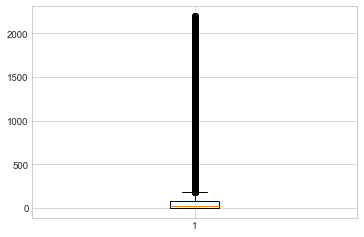

In [10]:
plt.boxplot(df.Amount)
plt.show()

Amounts are similar for both normal and fraudulent transactions

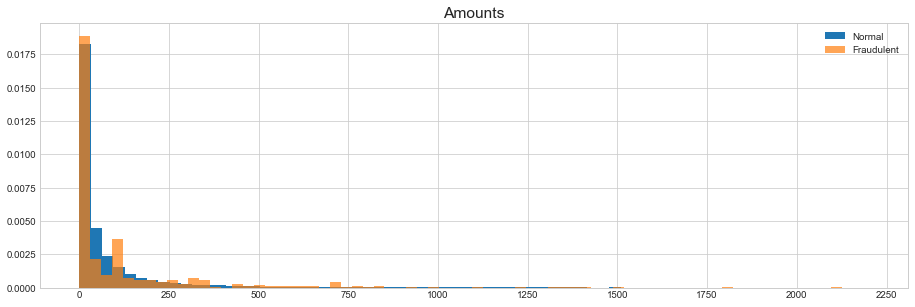

In [11]:
plt.figure(figsize=(16,5))
plt.hist(df[df.Class==0].Amount, bins=70, density=True, label='Normal')
plt.hist(df[df.Class==1].Amount, bins=70, density=True, alpha=0.7, label='Fraudulent')
plt.title('Amounts', fontsize=16)
plt.xticks([i for i in range(0, 2500, 250)])
plt.legend()
plt.show()

### Outliers for V1-V28 Features

Features `V1 - V28` are scaled to some degree. We can observe that these features have outliers on both ends

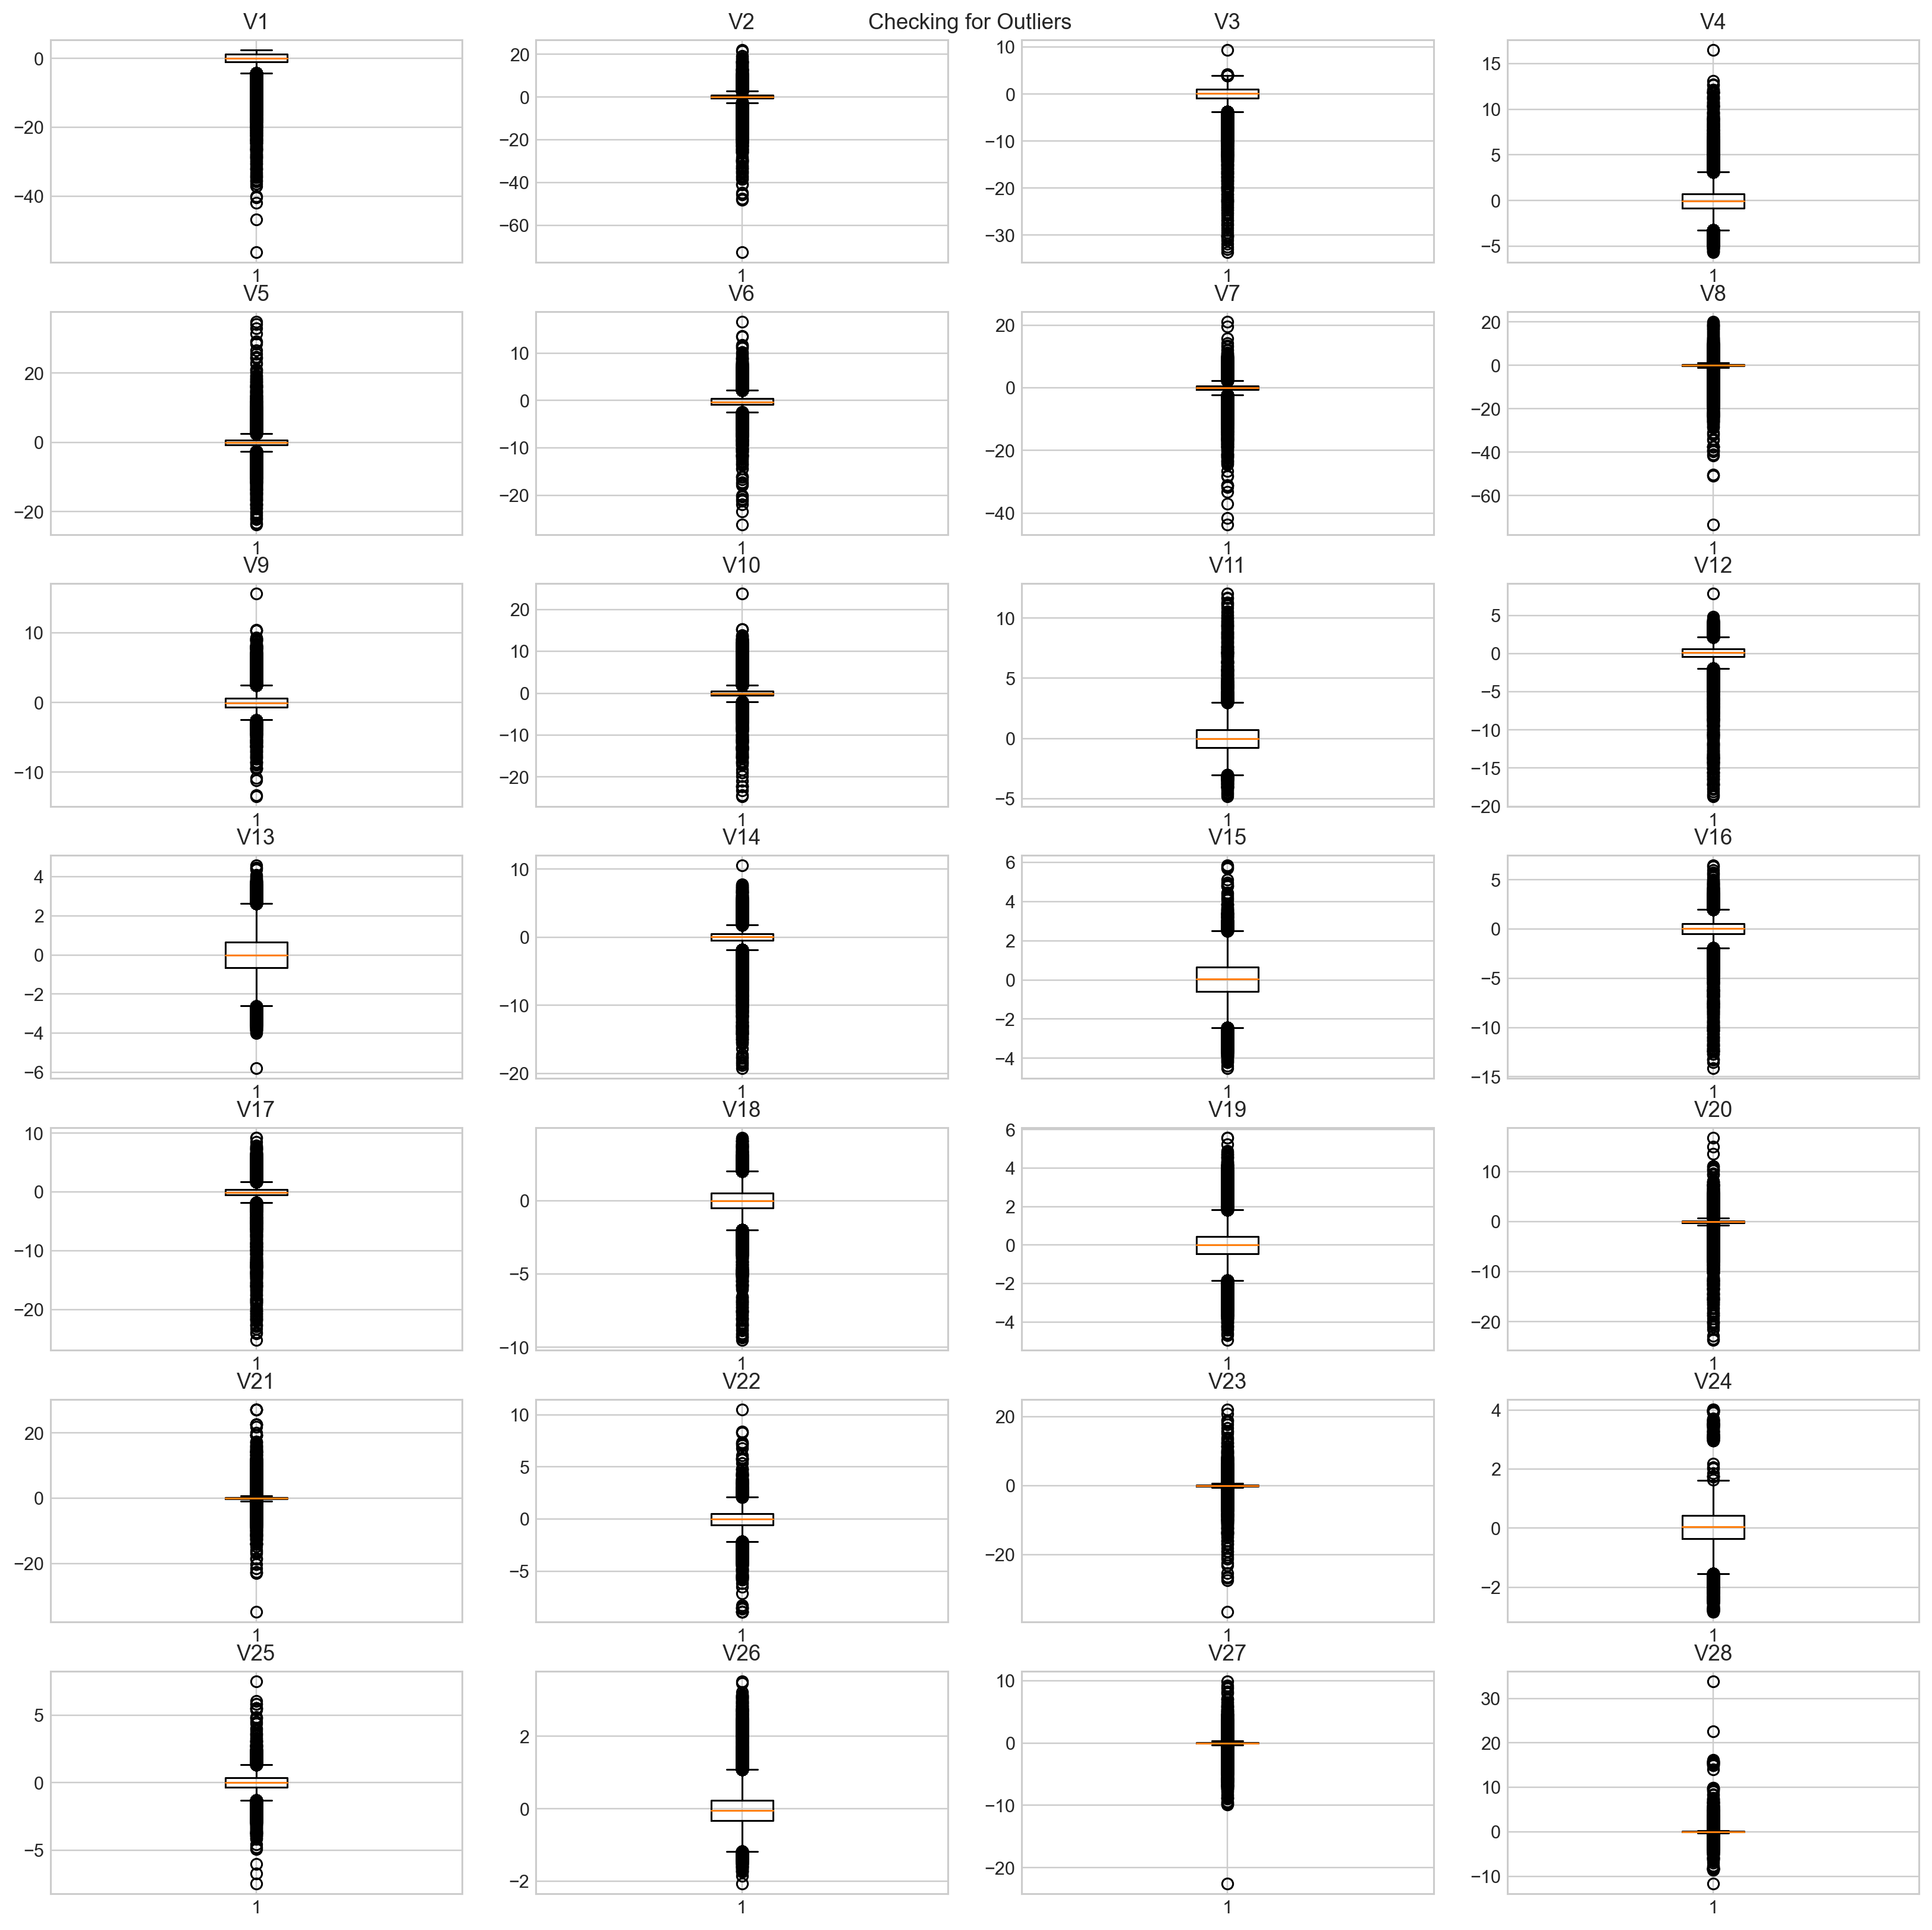

In [12]:
plt.rcParams['figure.dpi'] = 220
fig, axs = plt.subplots(7, 4, figsize=(15,15))
fig.suptitle('Checking for Outliers')
fig.tight_layout()

v = 1
for i in range(7):
    for j in range(4):
        axs[i, j].set_title(f'V{v}')
        axs[i, j].boxplot(df[f'V{v}'])
        v += 1

### <span id="eda_3">1.3 Correlations</span>

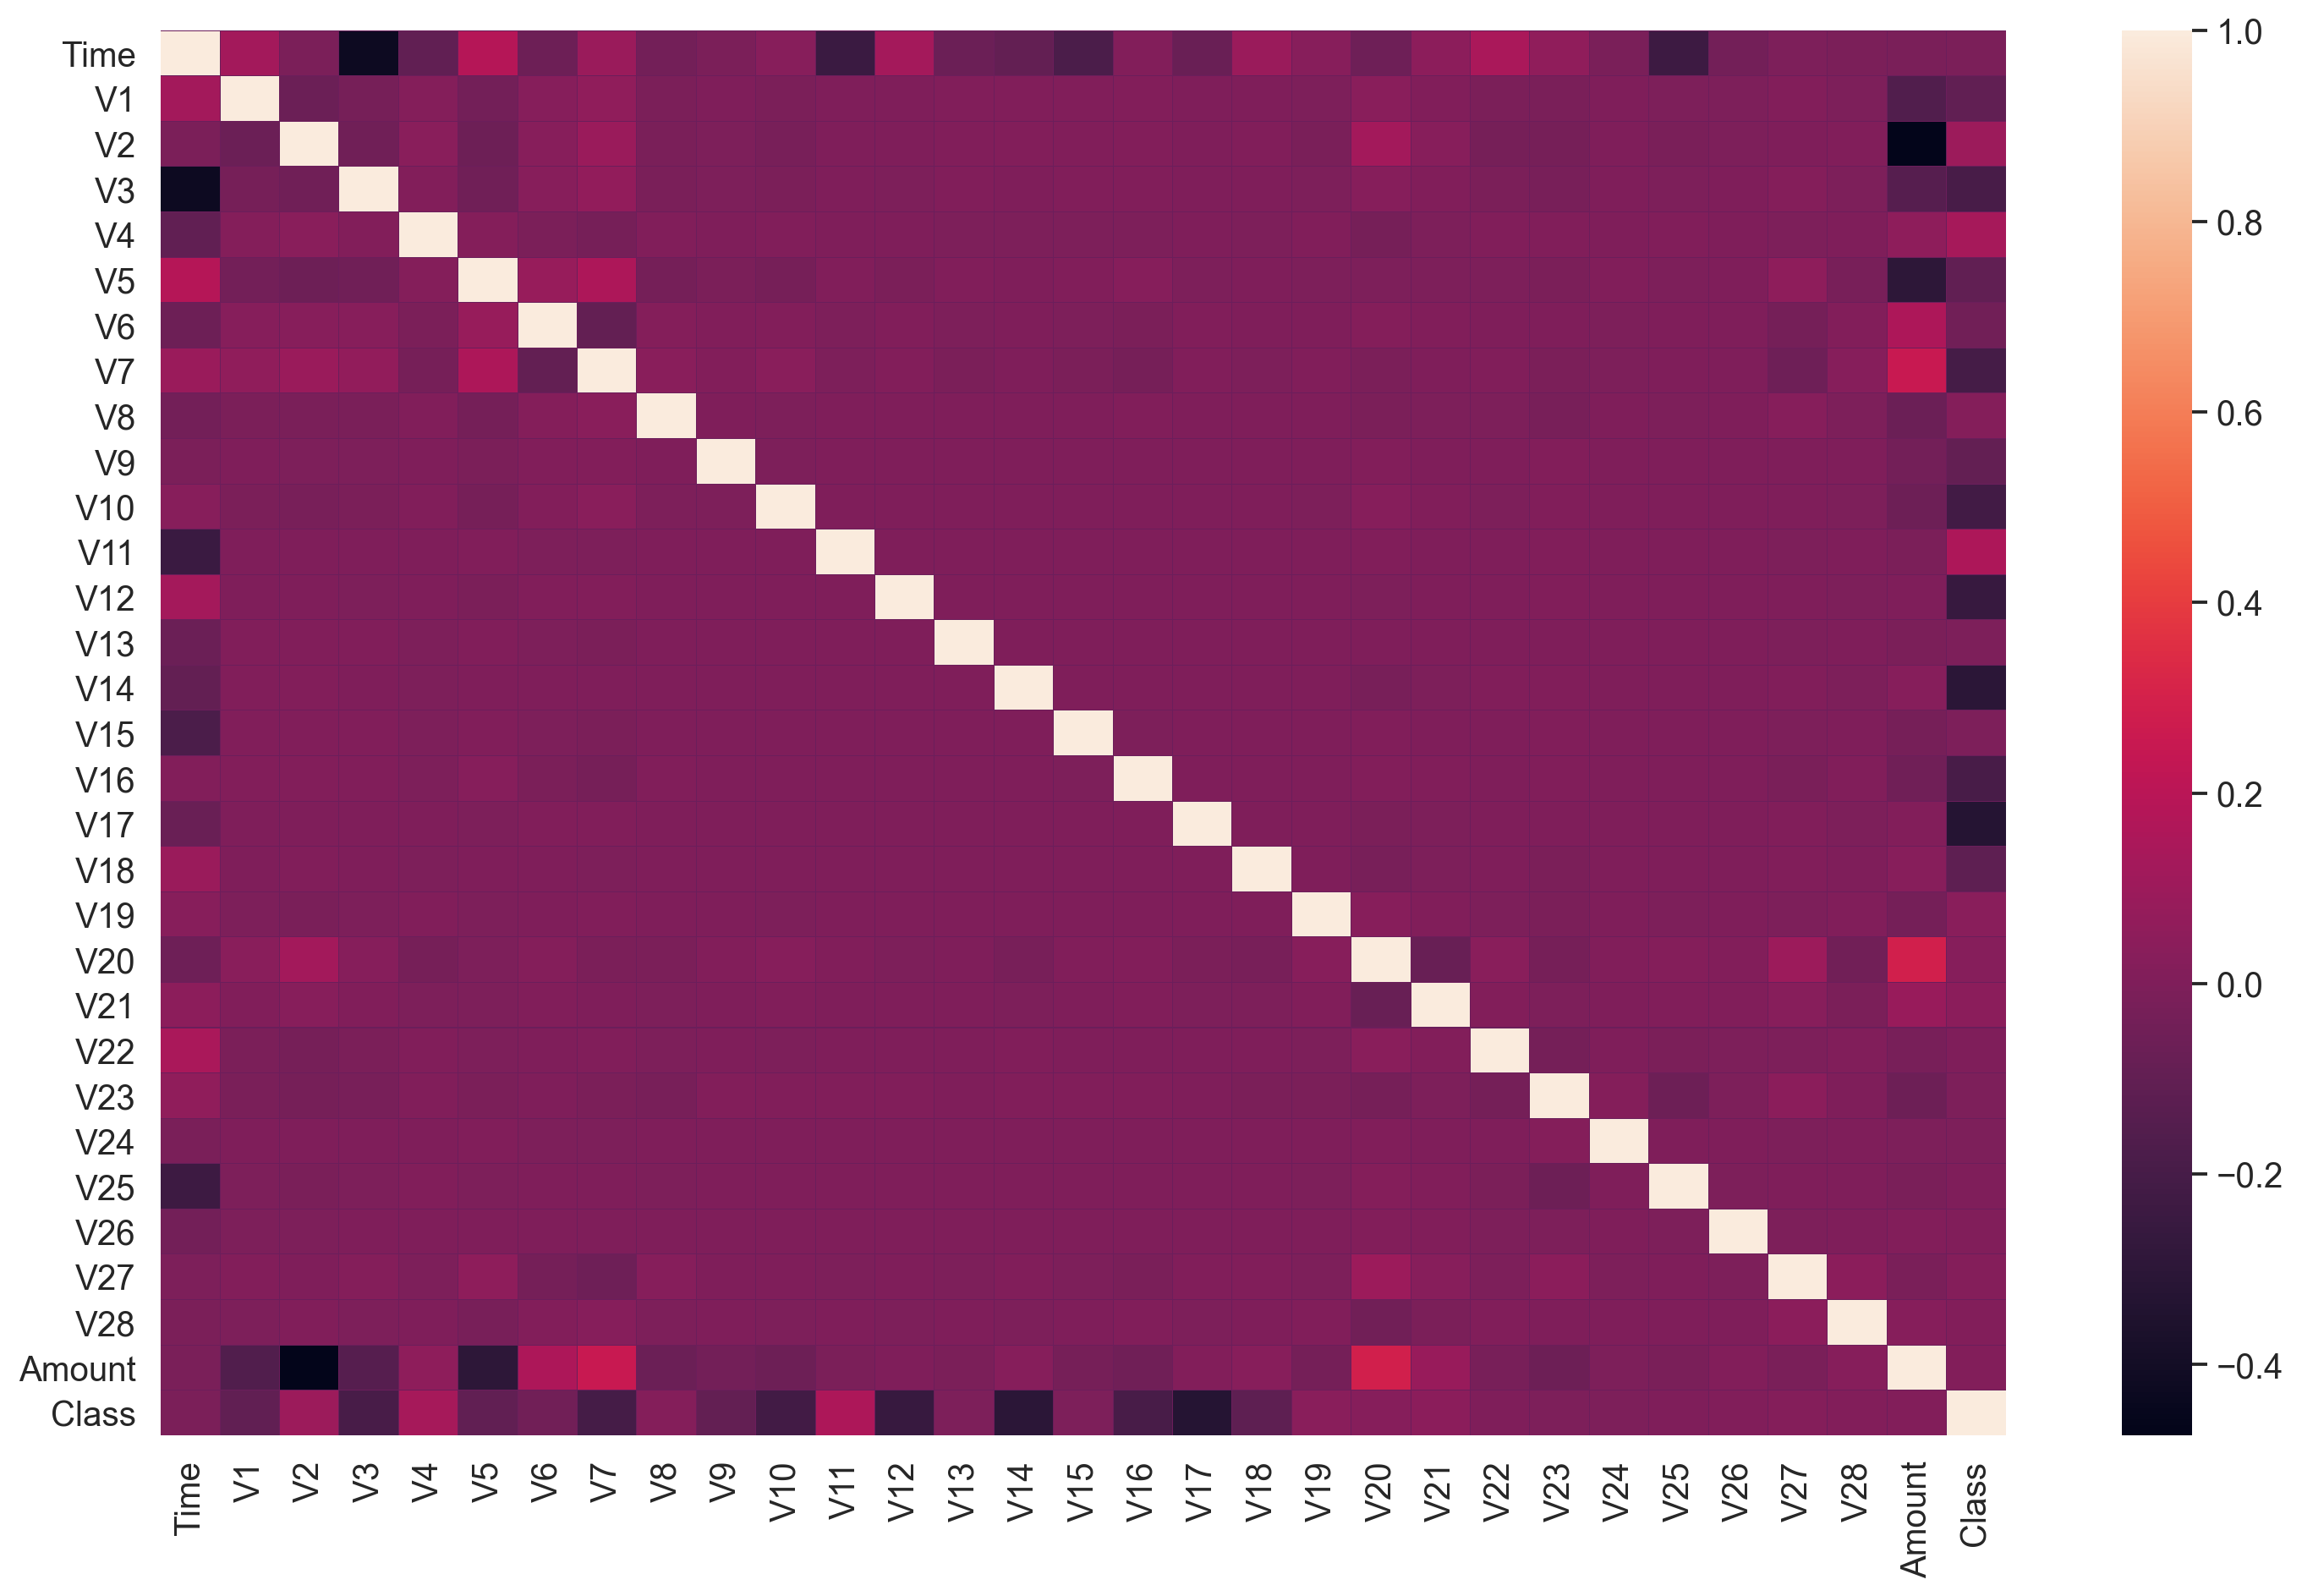

In [13]:
plt.figure(figsize=(16,10))
sns.set(font_scale=1.2)
sns.heatmap(df.corr(), linewidths=0.01, linecolor='#6b1e5b')
plt.show()

### <span id="eda_4">1.4 Features Visualization (2D) with Matplotlib</span>

We are going to use Principal Component Analysis to select 2 features with maximum variance

In [14]:
pca = PCA(2)
pca_features = pca.fit_transform(X=df.drop(['Time','Class'], axis=1), y=df.Class)

In [15]:
pca_2d = pd.DataFrame(pca_features, columns=['Feature 1', 'Feature 2'])
pca_2d['Class'] = df.Class

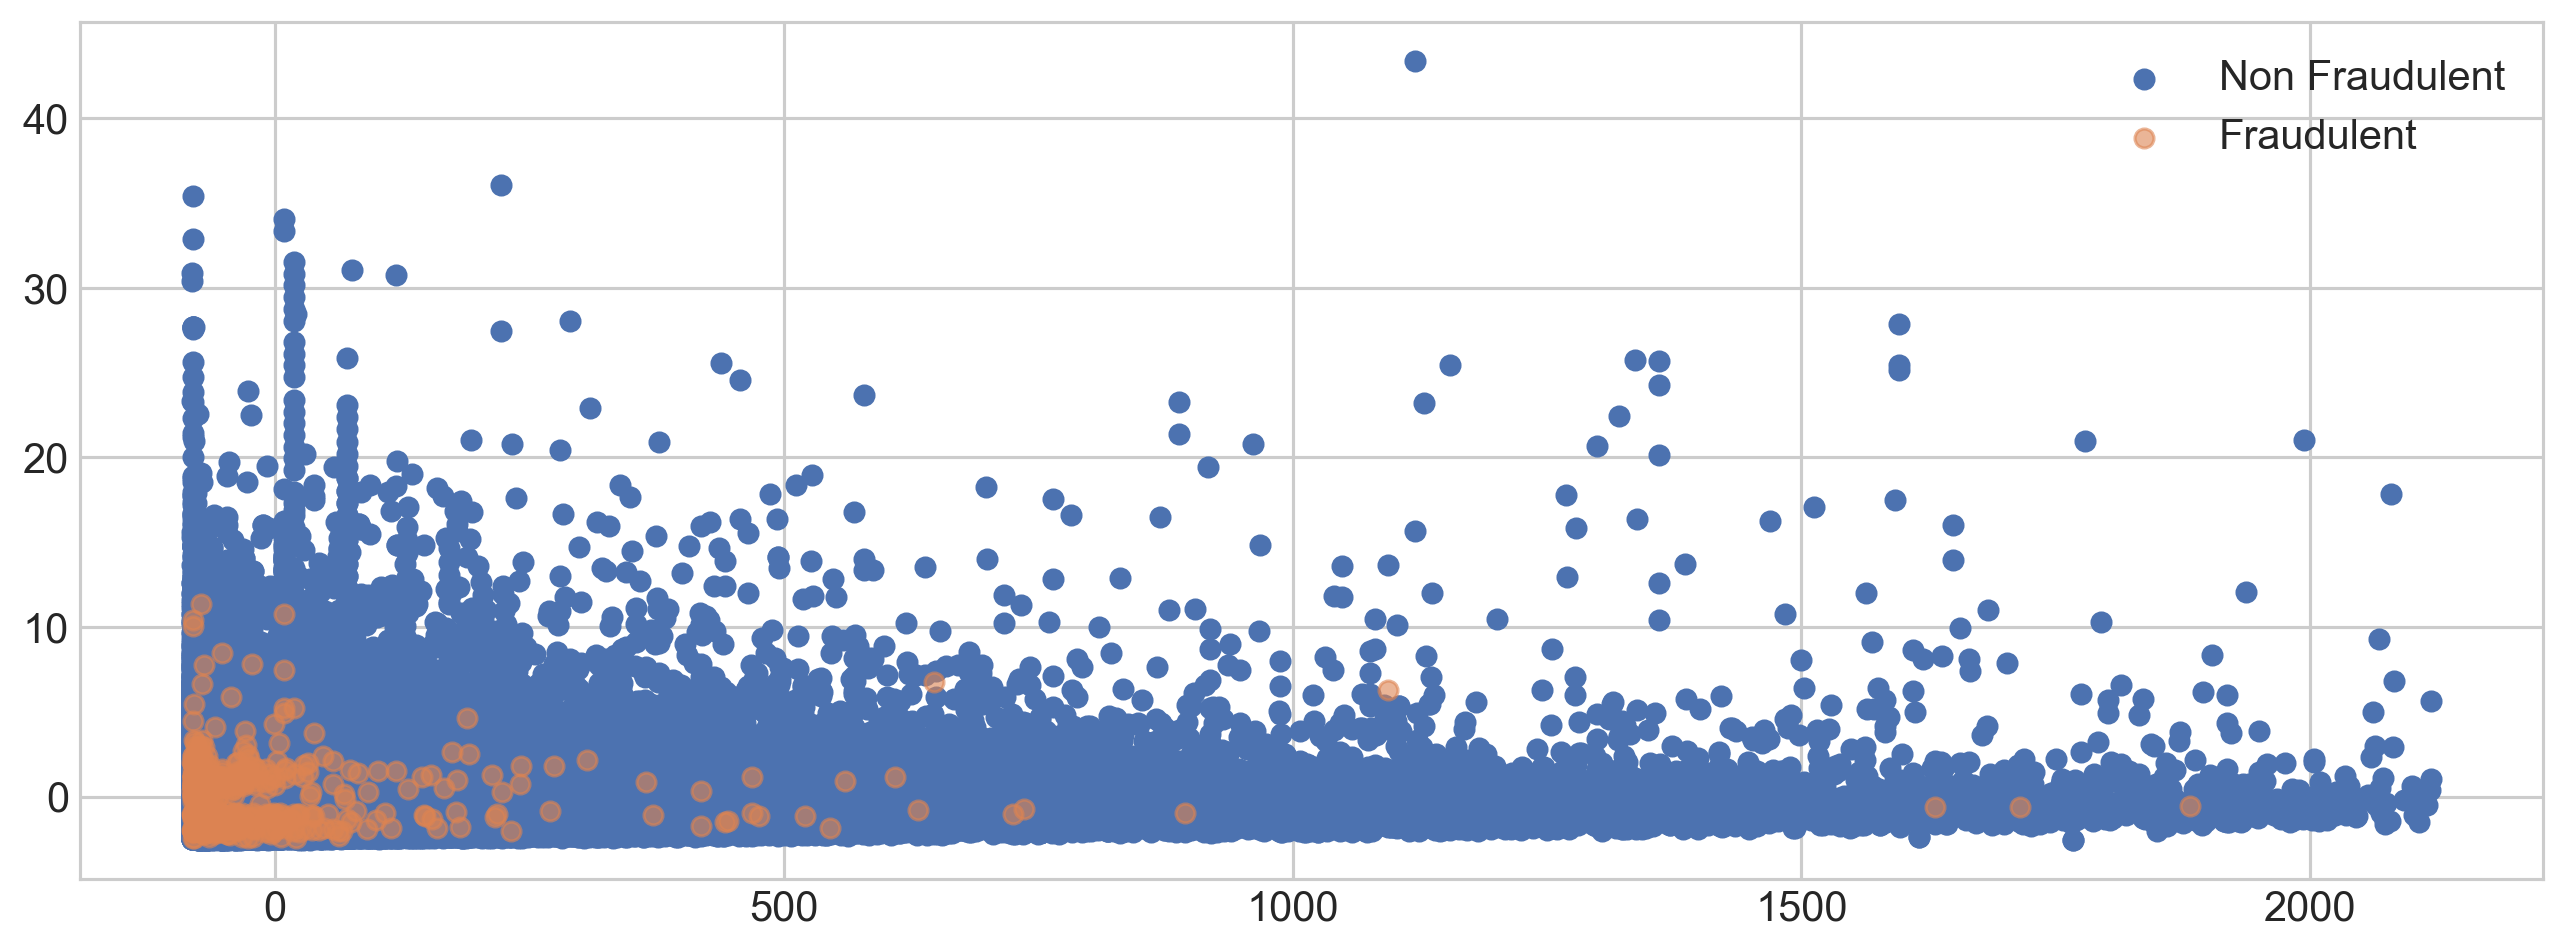

In [16]:
plt.rcParams['figure.dpi'] = 227
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(14,5))
plt.scatter(pca_2d[pca_2d.Class==0]['Feature 1'], pca_2d[pca_2d.Class==0]['Feature 2'])
plt.scatter(pca_2d[pca_2d.Class==1]['Feature 1'], pca_2d[pca_2d.Class==1]['Feature 2'], alpha=0.6)
plt.legend(['Non Fraudulent', 'Fraudulent'])
plt.show()

### <span id="eda_5">1.5 Features Visualization (3D) with Plotly</span>

In [17]:
df_sample = df[df.Class == 0].sample(150000)
df_sample = df_sample.append(df[df.Class == 1])

In [18]:
pca = PCA(3)
pca_features = pca.fit_transform(X = df_sample.drop(['Time','Class'], axis=1), y = df.Class)

In [19]:
pca_df = pd.DataFrame(pca_features, columns=['Feature 1', 'Feature 2', 'Feature 3'])
pca_df['Target'] = df_sample.Class.to_numpy()

In [ ]:
fig = px.scatter_3d(
    pca_df, 
    x='Feature 3', 
    y='Feature 2', 
    z='Feature 1',
    color='Target',
    width=1000,
    height=1000,
    opacity=1
)
fig.show()

## <span id="preprocessing">2. Preprocessing</span>&nbsp;&nbsp;<a href="#toc" title="Back to the table of contents">up</a>

In [21]:
X = df.drop(['Class'], axis=1)
y = df.Class

### <span id="preprocessing_1">2.1 Train-Test Split</span>

Before we decide how to work with class imbalance, we should split data into train and test parts to **avoid data leakage**

In [37]:
X_train, \
X_test, \
y_train, \
y_test = train_test_split(X, y, train_size=0.75)

### <span id="preprocessing_2">2.2 Scaling</span>

Scaling is important for some of the ML algorithms as it will reduce learning time and overall model performance. Tree-based models do not require any kind of normalization and will perform the same.

In [38]:
scaling = MinMaxScaler()
X_train = scaling.fit_transform(X_train)
X_test = scaling.transform(X_test)

### <span id="preprocessing_3">2.3 Class Imbalance (downsampling)</span>

We are going to try both down and upsampling and see which technique produces better results. Here downsampling technique is appied to `Train` part of the dataset. Result of this procedure is equally distributed positive and negative class.

In [24]:
downsample = NearMiss(n_jobs=-1)

In [25]:
X_train_down, y_train_down = downsample.fit_resample(X_train, y_train)

In [26]:
# y_train_down now has equal amounts of observations for each class
y_train_down.value_counts()

0    352
1    352
Name: Class, dtype: int64

In [27]:
# Test set contains data that model has no access to
y_test.value_counts()

0    70920
1      140
Name: Class, dtype: int64

### <span id="preprocessing_4">2.4 Class Imbalance (upsampling)</span>

Common technique is to use upsampling with `SMOTE` (Synthetic Minority Oversampling Technique), which produces equal amount of observation for both class by generating synthetic samples for minority class, in our case it is `Class 1`

In [28]:
upsample = SMOTE(n_jobs=-1)

In [29]:
X_train_up, y_train_up = upsample.fit_resample(X_train, y_train)

In [30]:
# y_train_down now has equal amounts of observations for each class
y_train_up.value_counts()

0    212827
1    212827
Name: Class, dtype: int64

In [31]:
# Test set contains data that model has no access to
y_test.value_counts()

0    70920
1      140
Name: Class, dtype: int64

## <span id="modeling">3. Modeling</span>&nbsp;&nbsp;<a href="#toc" title="Back to the table of contents">up</a>

Modeling part is all about trying different models, hyperparameters tuning, validation

### 3.1 <span id="modeling_1">Isolation Forest</span>

Isolation forest is the type of the tree based model that is used for identifying outliers. Without going into details of inner workings, we can fit the model on the `Class 0` only, then predict on the `Class 1` and observe how many positive (fraudulent) observations were labelled as outliers. Result will give an idea what result we can expect when applying models such as Logistic Regression and such.

In [32]:
clf = IsolationForest(n_estimators=100)
clf.fit(df[df.Class==0])
y_pred_outliers = clf.predict(df[df.Class==1])
sum(y_pred_outliers == -1) / len(y_pred_outliers)

0.8252032520325203

82.5% observations were correctly identified as outliers, which means 16.3% of the fraudulent transactions blend in with normal transactions.

### 3.2 <span id="modeling_2">Hyper Parameters Tuning for Logistic Regression (Imbalanced Data)</span>

First I want to find the best parameters for the logistic regression model on the original, imbalanced data. Logistic regression has `class_weight` parameter, which will help to overcome class imbalance by putting more attention to the minority class.

In [33]:
parameters = {
    'C': (0.01, 0.5, 1), 
    'class_weight': [{0: w1, 1: w2} for w1 in (0.05, 0.1) for w2 in (2.5, 3, 3.5, 4)]
}

logreg = LogisticRegression()
logreg_gridsearch = GridSearchCV(logreg, param_grid=parameters, scoring='recall', n_jobs=-1, cv=5)
logreg_gridsearch.fit(X_train, y_train)

logreg_gridsearch.best_estimator_

LogisticRegression(C=1, class_weight={0: 0.05, 1: 4})

In [34]:
# We won't need these anymore
try:
    del parameters, logreg, logreg_gridsearch
except:
    print('Parameters already got deleted')

### <span id="modeling_3">3.3 Logistic Regression with Optimal Parameters (Imbalanced Data)</span>

It makes no difference if I use `logreg_gridsearch` or start new model with the best parameters. For my own convenience I want to start with a clean slate and fit brand new model with optimal hyperparameters

In [35]:
logreg = LogisticRegression(C=1, class_weight={0: 0.05, 1: 4})

In [36]:
logreg.fit(X_train, y_train)

LogisticRegression(C=1, class_weight={0: 0.05, 1: 4})

In [39]:
y_pred = logreg.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70934
           1       0.54      0.82      0.65       126

    accuracy                           1.00     71060
   macro avg       0.77      0.91      0.82     71060
weighted avg       1.00      1.00      1.00     71060

--------------------------------------------------------------------------------
Cross-Validation Score (Recall): 0.7449230769230769
--------------------------------------------------------------------------------


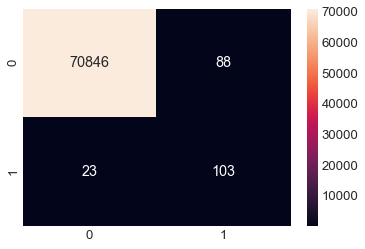

--------------------------------------------------------------------------------


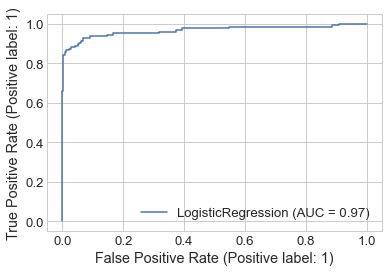

In [47]:
evaluation(logreg, X_train, y_train, X_test, y_test, y_pred)

In [48]:
'''
false_negative = pd.DataFrame(y_test)
false_negative['Prediction'] = y_pred
fn_index = false_negative[(false_negative['Class'] == 1) & (false_negative['Prediction'] == 0)].index
tp_index = false_negative[(false_negative['Class'] == 1) & (false_negative['Prediction'] == 1)].index
scaling.inverse_transform(df.loc[tp_index].Amount.to_numpy().reshape(-1, 1)).mean()
scaling.inverse_transform(df.loc[fn_index].Amount.to_numpy().reshape(-1, 1)).mean()
'''

"\nfalse_negative = pd.DataFrame(y_test)\nfalse_negative['Prediction'] = y_pred\nfn_index = false_negative[(false_negative['Class'] == 1) & (false_negative['Prediction'] == 0)].index\ntp_index = false_negative[(false_negative['Class'] == 1) & (false_negative['Prediction'] == 1)].index\nscaling.inverse_transform(df.loc[tp_index].Amount.to_numpy().reshape(-1, 1)).mean()\nscaling.inverse_transform(df.loc[fn_index].Amount.to_numpy().reshape(-1, 1)).mean()\n"

### <span id="modeling_4">3.4 Logistic Regression on Balanced Data (Downsampling)</span>

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     70934
           1       0.05      0.82      0.10       126

    accuracy                           0.97     71060
   macro avg       0.53      0.90      0.54     71060
weighted avg       1.00      0.97      0.98     71060

--------------------------------------------------------------------------------
Cross-Validation Score (Recall): 0.42030769230769227
--------------------------------------------------------------------------------


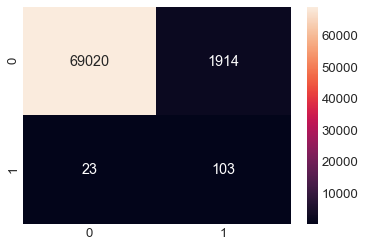

--------------------------------------------------------------------------------


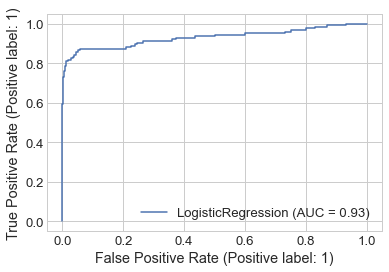

In [54]:
logreg = LogisticRegression()
logreg.fit(X_train_down, y_train_down)
y_pred = logreg.predict(X_test)
evaluation(logreg, X_train, y_train, X_test, y_test, y_pred)

### <span id="modeling_5">3.5 Logistic Regression on Balanced Data (Upsampling)</span>

              precision    recall  f1-score   support

           0       1.00      0.81      0.89     70934
           1       0.01      0.94      0.02       126

    accuracy                           0.81     71060
   macro avg       0.50      0.88      0.46     71060
weighted avg       1.00      0.81      0.89     71060

--------------------------------------------------------------------------------
Cross-Validation Score (Recall): 0.42030769230769227
--------------------------------------------------------------------------------


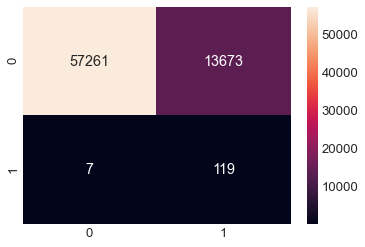

--------------------------------------------------------------------------------


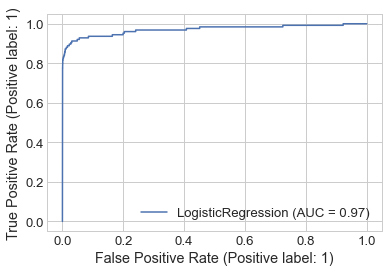

In [55]:
logreg = LogisticRegression(C=1)
logreg.fit(X_train_up, y_train_up)
y_pred = logreg.predict(X_test)
evaluation(logreg, X_train, y_train, X_test, y_test, y_pred)

### <span id="modeling_6">3.6 Random Forest on Balanced Data (Downsampling)</span>

              precision    recall  f1-score   support

           0       1.00      0.00      0.00     70934
           1       0.00      1.00      0.00       126

    accuracy                           0.00     71060
   macro avg       0.50      0.50      0.00     71060
weighted avg       1.00      0.00      0.00     71060

--------------------------------------------------------------------------------
Cross-Validation Score (Recall): 0.42030769230769227
--------------------------------------------------------------------------------


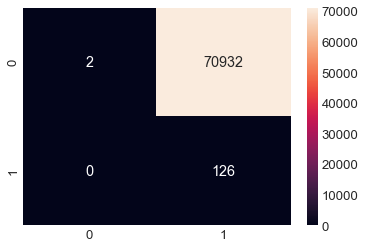

--------------------------------------------------------------------------------


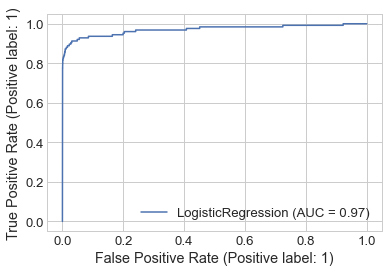

Execution Time: 1.62 sec.


In [61]:
start = time()
random_forest = RandomForestClassifier(n_jobs=-1)
random_forest.fit(X_train_down, y_train_down)
y_pred = random_forest.predict(X_test)
evaluation(logreg, X_train, y_train, X_test, y_test, y_pred)
print(f'Execution Time: {(time() - start):.2f} sec.')

### <span id="modeling_7">3.7 Random Forest on Balanced Data (Upsampling)</span>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70934
           1       0.86      0.75      0.80       126

    accuracy                           1.00     71060
   macro avg       0.93      0.88      0.90     71060
weighted avg       1.00      1.00      1.00     71060

--------------------------------------------------------------------------------
Cross-Validation Score (Recall): 0.42030769230769227
--------------------------------------------------------------------------------


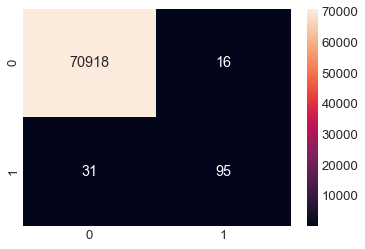

--------------------------------------------------------------------------------


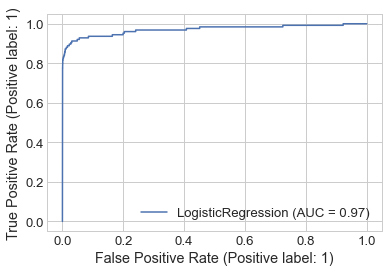

Execution Time: 79.99 sec.


In [62]:
start = time()
random_forest = RandomForestClassifier(n_jobs=-1)
random_forest.fit(X_train_up, y_train_up)
y_pred = random_forest.predict(X_test)
evaluation(logreg, X_train, y_train, X_test, y_test, y_pred)
print(f'Execution Time: {(time() - start):.2f} sec.')

## <span id="conclusion">4. Conclusion</span>&nbsp;&nbsp;<a href="#toc" title="Back to the table of contents">up</a>